This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction, fitter, plot_utils

flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

# Select data

In [3]:
# Density data
grid = pd.read_parquet(data_path / "data_density.parquet")
grid_window = pd.read_parquet(data_path / "data_window_density.parquet")

coordinates_density = np.array([grid["ra"], grid["dec"], grid["rcom_zobs"]])

DataDensity = data_vector.Dens(grid.to_dict(orient='list'))


# Velocity data
data_velocity = pd.read_parquet(data_path / "data_velocity.parquet")
coordinates_velocity = np.array([data_velocity["ra"], data_velocity["dec"], data_velocity["rcom_zobs"]])
data_velocity_true = {**data_velocity.to_dict(orient='list'), 
                      "velocity_error": np.zeros(len(data_velocity["velocity"].values))}


# Create the True Vel data vector
DataTrueVel = data_vector.DirectVel(data_velocity_true)

# Create the Vel data vector
DataVel = data_vector.snia_vectors.VelFromSALTfit(data_velocity.to_dict(orient='list'), velocity_estimator='full', h=0.70)


DensTrueVel = data_vector.DensVel(DataDensity, DataTrueVel)

DensVel = data_vector.DensVel(DataDensity, DataVel)


sigmau_fiducial = 15.0
sigmag_fiducial = 3.0

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")
power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {
    "gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],[kmt, pmt * np.array(grid_window["window_mt"])],[ktt, ptt]],
    "gv": [[kmt, pmt * np.array(grid_window["window_mt"]) * utils.Du(kmt, sigmau_fiducial)],[ktt, ptt* utils.Du(kmt, sigmau_fiducial)]],
    "vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial)**2]]
}

# Fit with true velocities

In [4]:
size_batch=500_000
number_worker=8

covariance_fit = covariance.CovMatrix.init_from_flip(
    "ravouxcarreres",
    "full",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
    variant="nobeta",
)


/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000041.02 ]: 01-19 02:56  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 6.76e+00 seconds


In [5]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky", "use_jit":True}


parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DensTrueVel,
        parameter_dict,
        likelihood_type = likelihood_type,
        likelihood_properties = likelihood_properties
)

print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()

Free parameters are: ['bs8', 'sigv', 'fs8']


[ 000043.50 ]: 01-19 02:56  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4160                       │              Nfcn = 123              │
│ EDM = 1.58e-06 (Goal: 0.0001)    │            time = 2.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'bs8': 0.901674523029119,
 'fs8': 0.39971261542335657,
 'sigv': 340.4366820444796}

# Fit with estimated velocities

In [6]:
size_batch=500_000
number_worker=8

covariance_fit = covariance.CovMatrix.init_from_flip(
    "ravouxcarreres",
    "full",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
    variant="nobeta",
)

[ 000050.52 ]: 01-19 02:56  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 7.01e+00 seconds


In [7]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky"}

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DensVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

print('Free parameters are:', minuit_fitter_velest.likelihood.free_par)

minuit_fitter_velest.run()

/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Free parameters are: ['alpha', 'beta', 'M_0', 'sigma_M', 'bs8', 'sigv', 'fs8']


[ 000061.06 ]: 01-19 02:56  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4466                       │              Nfcn = 313              │
│ EDM = 8.45e-06 (Goal: 0.0001)    │           time = 10.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬────────

{'bs8': 0.9976444706295119,
 'fs8': 0.25068972619642094,
 'sigv': 0.5951206568853102,
 'alpha': 0.1266669622907818,
 'beta': 3.1009235817385856,
 'M_0': -19.065745664084513,
 'sigma_M': 0.14364266351389385}

# Some plots

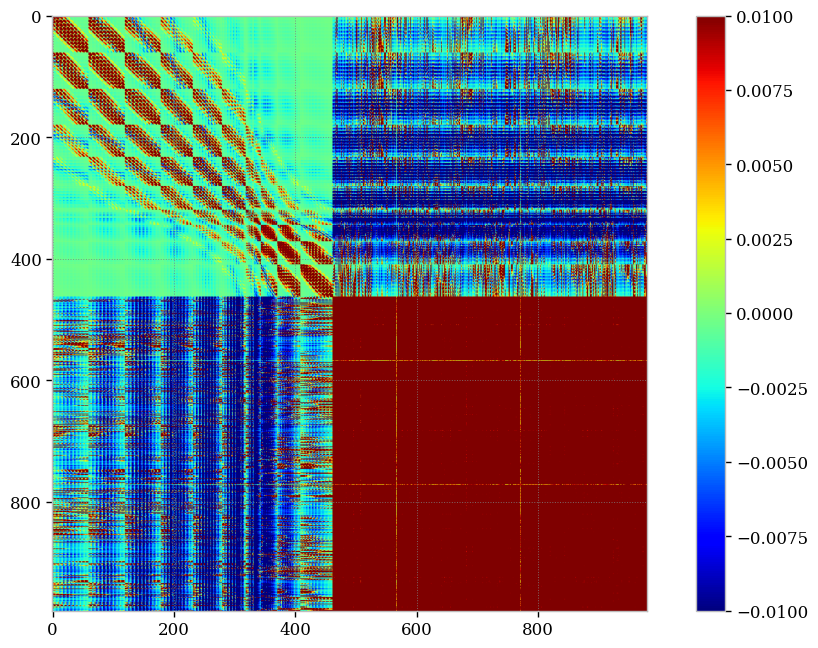

In [8]:
plot_utils.plot_correlation_from_likelihood(minuit_fitter_velest.likelihood,
                                            parameter_dict,
                                            vmin=-0.01,vmax=0.01)

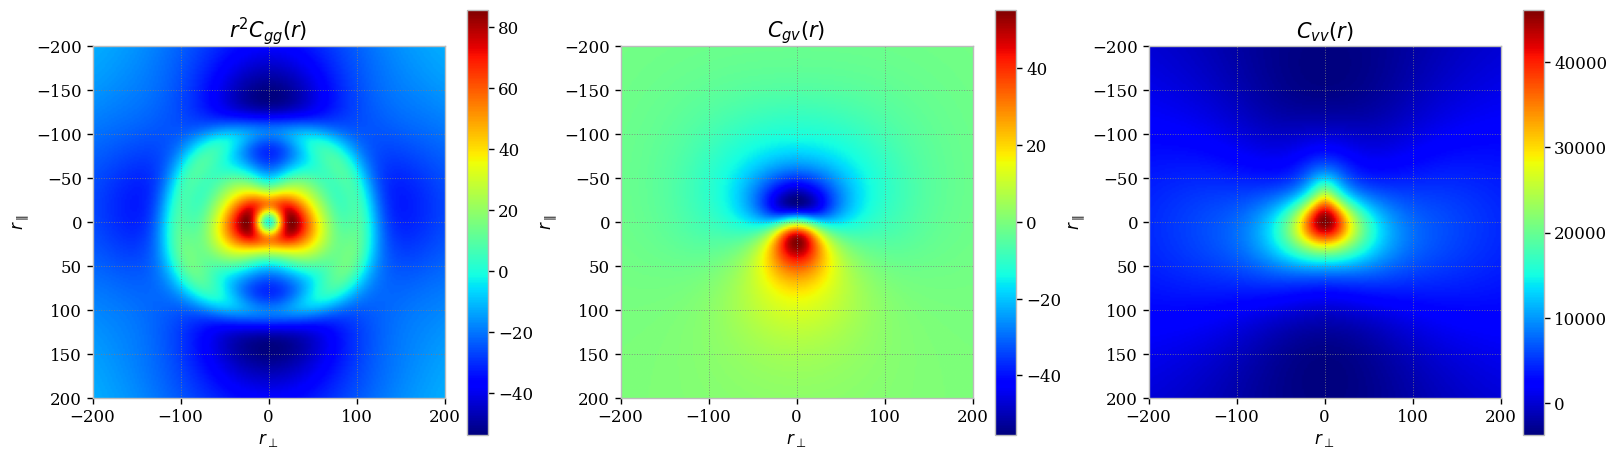

In [9]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "ravouxcarreres",
    "full",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
    variant="nobeta",
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
